In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os 
import multiprocessing
import jax
from cohlib.utils import add0
import jax.random as jr


os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={multiprocessing.cpu_count()}"
# os.environ["XLA_FLAGS"] = f"--xla_force_host_platform_device_count={10}"
jax.config.update('jax_platform_name', 'cpu')
platform = jax.lib.xla_bridge.get_backend().platform.casefold()
print("Platform: ", platform)
print(len(jax.devices()))

Platform:  cpu
28


In [3]:
import jax.numpy as jnp
import matplotlib.pyplot as plt

from cohlib.utils import pickle_open
from cohlib.confs.utils import omega

from cohlib.utils import rotate_eigvecs, naive_estimator
import cohlib.confs.utils as conf

In [4]:
def plot_latent_sim_data(ax, K, L, seed, rankname='rank1', gamma_seed=0, color='tab:blue', ell=0, unit=0, alpha=0.5):
    if ax is None: 
        ax = plt.gca()

    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    latent_load = pickle_open(latent_path)
    zs_nz = latent_load['zs_nz']
    nz = latent_load['nz']
    freqs = latent_load['freqs']
    num_freqs = freqs.size
    lcfg = latent_load['lcfg']
    lcfg = conf.omega(lcfg)

    zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    xvals = jnp.arange(xs.shape[0]) / 1000
    ax.plot(xvals, xs[:,unit,ell], color='tab:blue', alpha=alpha)

In [5]:
def plot_obs_sim_data(ax, K, L, seed, mu, rankname='rank1', gamma_seed=0, color='tab:blue', ell=0, unit=0, alpha=0.5):
    if ax is None: 
        ax = plt.gca()

    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    obs_load = pickle_open(obs_path)
    obs = obs_load['obs']

    xvals = jnp.arange(obs.shape[0]) / 1000
    ax.plot(xvals, obs[:,unit,ell], color='tab:blue', alpha=alpha)

In [47]:
def load_latent_data(K, L, seed, rankname='rank1', gamma_seed=0):
    latent_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/latent_sim.pkl'

    latent_load = pickle_open(latent_path)
    zs_nz = latent_load['zs_nz']
    nz = latent_load['nz']
    freqs = latent_load['freqs']
    num_freqs = freqs.size
    lcfg = latent_load['lcfg']
    lcfg = conf.omega(lcfg)

    zs = jnp.zeros((num_freqs, lcfg.K, lcfg.L), dtype=complex)
    zs = zs.at[nz,:,:].set(zs_nz)
    zs_0dc = jnp.apply_along_axis(add0, 0, zs)
    xs = jnp.fft.irfft(zs_0dc, axis=0)

    return latent_load, xs

In [24]:
def load_obs_data(K, L, seed, mu, rankname='rank1', gamma_seed=0):
    obs_path = f'/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_log_{rankname}/window1000/gseed{gamma_seed}/K{K}/L{L}/lseed{seed}/obs-pp_log/mu{mu}/oseed{seed}/obs_sim.pkl'
    obs_load = pickle_open(obs_path)
    # obs = obs_load['obs']

    return obs_load

In [52]:
seed = 0
mu = 2.0
latent_load, xs = load_latent_data(3, 25, seed, rankname='rank1', gamma_seed=0)
obs_load = load_obs_data(3, 25, seed, mu, rankname='rank1', gamma_seed=0)
obs = obs_load['obs']
print(obs.sum(0).mean(1))

[15.799999 17.92     16.76    ]


In [82]:
mu = 2.4
jnp.exp(mu + xs).sum(0).mean(1) * 1e-3

Array([24.70129 , 24.701292, 24.701296], dtype=float32)

In [45]:
jnp.exp(2)

Array(7.389056, dtype=float32, weak_type=True)

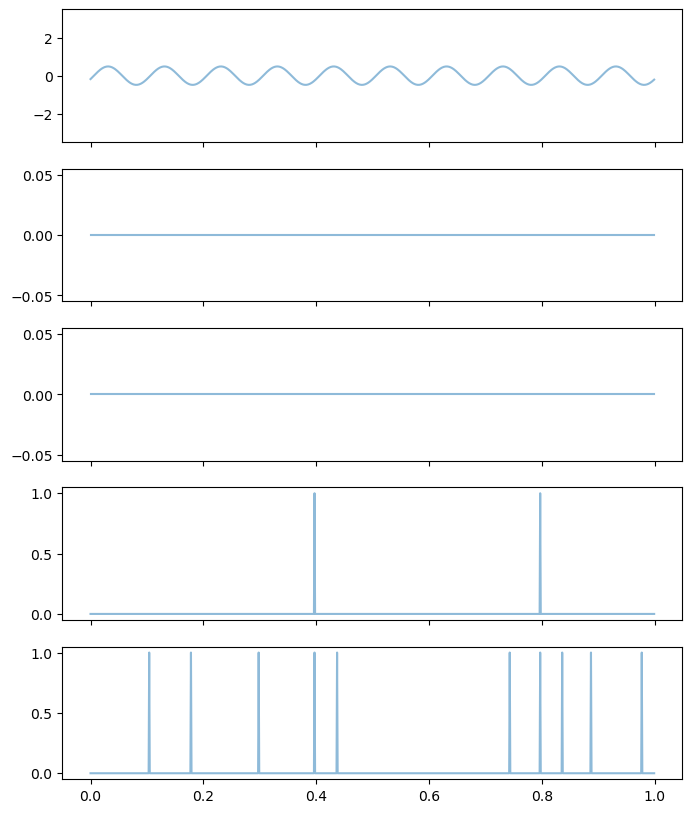

In [39]:
seed = 0
lshow = 10
fig, axs = plt.subplots(5,1,figsize=(8,10), sharex=True)

plot_latent_sim_data(axs[0], 3, 25, seed, ell=lshow, rankname='rank1', gamma_seed=0)
axs[0].set_ylim(-3.5, 3.5)

for i, mu in enumerate([-2.0, -1.0, 0.0, 2.0]):
    plot_obs_sim_data(axs[i+1], 3, 25, seed, mu, ell=lshow, rankname='rank1', gamma_seed=0)
    # axs[i,1].set_ylim(-3.5, 3.5)


In [7]:
def mod_config(cfg, L, theta):
    cfg.latent.L = L
    if cfg.obs.obs_type == 'gaussian':
        cfg.obs.ov2 = theta
    elif cfg.obs.obs_type in ['pp_relu', 'pp_log']:
        cfg.obs.mu = theta
    else:
        raise ValueError

    return cfg


# Eigvals

In [8]:
def plot_eigval_var_L_subplot(ax, plot_dict, drop_emp):
    naive_color = 'tab:red'
    naive_style = 'dashed'
    naive_width = 2

    true_color = 'k'
    true_style = 'solid'
    true_width = 2

    oracle_color = 'tab:green'
    oracle_style = 'dotted'
    oracle_width = 2.5

    est_color = 'tab:blue'
    est_style = 'solid'
    est_width = 2

    ev_true = plot_dict['eigval_true']
    ev_oracle = plot_dict['eigval_oracle']
    ev_naive = plot_dict['eigval_naive']
    evs_em = plot_dict['eigvals_em']

    ax.axhline(ev_true, linestyle=true_style, color=true_color, linewidth=true_width)
    ax.axhline(ev_oracle, linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
    if drop_emp is False:
        ax.axhline(ev_naive, linestyle=naive_style, color=naive_color, linewidth=naive_width)
    ax.plot(evs_em, color=est_color, linestyle=est_style, linewidth=est_width)

def get_theta_label(ocfg, theta):
    if ocfg.obs_type == 'gaussian':
        label = f'{ocfg.ov1}e{theta}'
    elif ocfg.obs_type in ['pp_relu', 'pp_log']:
        label = f'{ocfg.mu}'
    else:
        return ValueError
    return label

def get_ccn_fullrank_eigvals(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    eigvals_raw, _ = jnp.linalg.eigh(gamma)
    eigvals = eigvals_raw[:,::-1]
    return eigvals

In [9]:
from cohlib.plot import get_eigval
eigrank = 1
thetas = [-2.0, -1.0, 0.0, 1.0, 2.0]
jind_nz = 0

def get_plot_dict_eigvals(cfg):

    plot_data = {}
    for l, L in enumerate(Ls):
        for t, theta in enumerate(thetas):
            print(f'gathering data for L={L}, theta={theta}')
            cfg = mod_config(cfg, L, theta)

            # context initialization
            nz_model = jnp.array([cfg.latent.target_freq_ind])
            temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
                            'nz_model': nz_model, 'K': cfg.latent.K}
            model_dir = conf.get_model_dir(cfg, temp_params)

            res = pickle_open(os.path.join(model_dir, 'res.pkl'))

            lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
            plot_data[t,l] = {}
            plot_data[t,l]['eigval_true'] = lrccn_true.eigvals[0,eigrank-1]
            eigvals_em = jnp.stack([get_ccn_fullrank_eigvals(x)[0,eigrank-1] for x in res['track']['ccn']])
            plot_data[t,l]['eigvals_em'] = eigvals_em

            # load zs data and compute oracle est
            latent_dir = conf.get_latent_dir(cfg.latent)
            latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
            zs_nz = latent_load['zs_nz']
            nz_true = latent_load['nz']
            jind_nz = 0

            # TODO fix for 
            gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
            oracle_eigval = get_eigval(gamma_oracle[jind_nz,:,:], eigrank)
            plot_data[t,l]['eigval_oracle'] = oracle_eigval

            obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
            obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
            obs = obs_load['obs']

            if cfg.model.inherit_lcfg is True:
                nz_model = nz_true
            else:
                raise NotImplementedError

            obs_type = cfg.obs.obs_type
            if obs_type == 'gaussian':
                naive_est = naive_estimator(obs, nz_model)
            elif obs_type in ['pp_relu', 'pp_log']:
                naive_est = naive_estimator(obs, nz_model)*1e6
            else:
                raise ValueError
            naive_eigval = get_eigval(naive_est[jind_nz,:,:], eigrank)
            plot_data[t,l]['eigval_naive'] = naive_eigval

    return plot_data



In [13]:
gseed_use = 0
seed_use = 1
temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_rank1/window1000/gseed0/K3/L25/lseed0/obs-gaussian/ovb1.0_ove-1.0/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/empirical-init/newton-10_em-20/res.pkl"
# temp = "/projectnb/stephenlab/jtauber/cohlib/experiments/data/latent-basic_single_rank1/window1000/gseed0/K3/L5/lseed0/obs-gaussian/ovb1.0_ove-1.0/oseed0/model-simple_inherit_latent_fullrank/inherit-True/m_step-full-rank-standard/oracle-init/newton-10_em-20/res.pkl"
res = pickle_open(temp)
cfg = conf.omega(res['cfg'])

cfg.latent.gamma_seed = gseed_use
cfg.latent.seed = seed_use
cfg.obs.seed = seed_use
nz_model = jnp.array([cfg.latent.target_freq_ind])

gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0


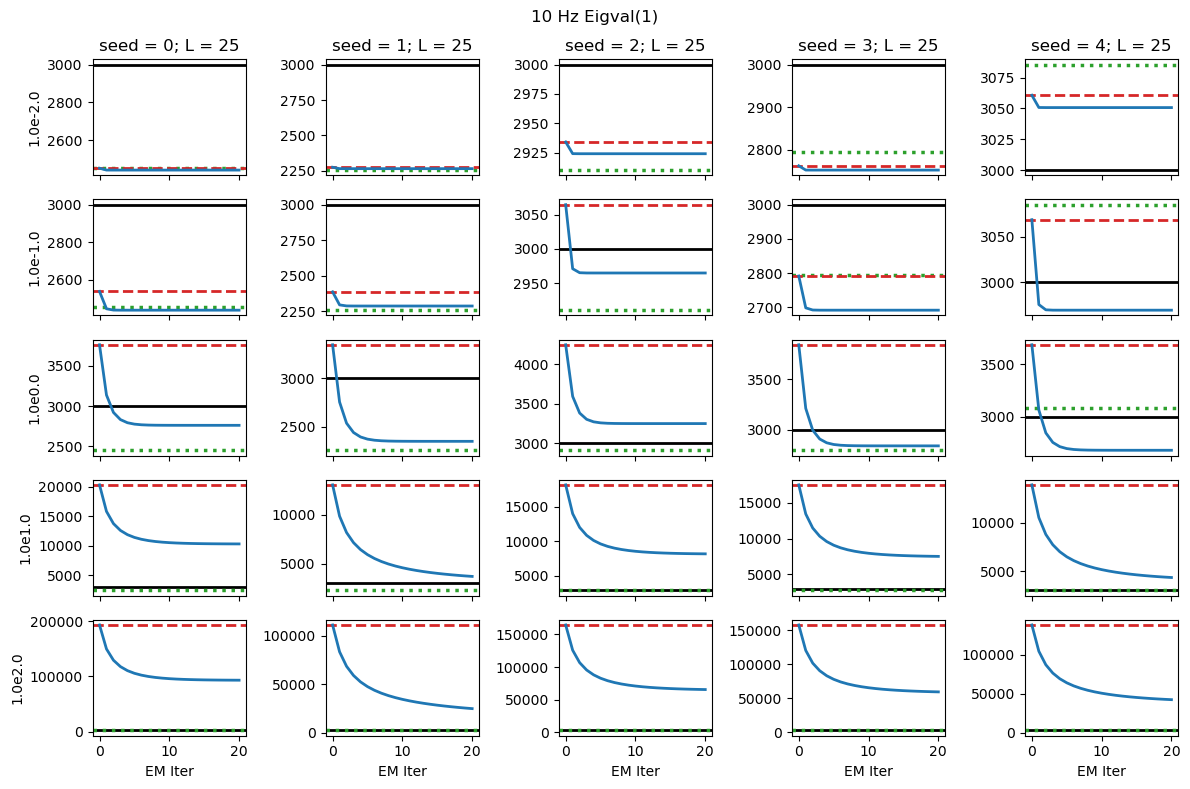

In [16]:
Ls = [25]
m = 0
nseeds = 5
seeds = [x + nseeds*m for x in range(nseeds)]
# fig, ax = plt.subplots(len(thetas), len(seeds), figsize=(12,8), sharex=True, sharey='row')
fig, ax = plt.subplots(len(thetas), len(seeds), figsize=(12,8), sharex=True, sharey=False)


# for l, L in enumerate(Ls):
l = 0
L = Ls[0]
for s, seed_use in enumerate(seeds):
    cfg.latent.gamma_seed = gseed_use
    cfg.latent.seed = seed_use
    cfg.obs.seed = seed_use
    nz_model = jnp.array([cfg.latent.target_freq_ind])
    plot_data = get_plot_dict_eigvals(cfg)

    for t, theta in enumerate(thetas):
        axp = ax[t,s]

        plot_eigval_var_L_subplot(ax[t,s], plot_data[t,l], drop_emp=False)

        if s == 0:
            ax[t,s].set_ylabel(f'{get_theta_label(cfg.obs, theta)}')
        if t == 0:
            ax[t,s].set_title(f'seed = {seed_use}; L = {L}')
        if t == len(thetas)-1:
            ax[t,s].set_xlabel('EM Iter')

fig.suptitle(f'{nz_model[jind_nz]+1} Hz ' + rf'Eigval({eigrank})')
plt.tight_layout()

# Eigvecs

In [17]:
def get_ccn_fullrank_eigvecs(ccn):
    """
    ccn.gamma shape (J x K x K)
    """
    gamma = ccn.gamma
    _, eigvecs_raw = jnp.linalg.eigh(gamma)
    eigvecs = eigvecs_raw[:,:,::-1]
    return eigvecs

def plot_eigvec_var_L_subplot(ax, plot_dict, dim, func, funcname):
    naive_color = 'tab:red'
    naive_style = 'dashed'
    naive_width = 2

    true_color = 'k'
    true_style = 'solid'
    true_width = 2

    oracle_color = 'tab:green'
    oracle_style = 'dotted'
    oracle_width = 2.5

    est_color = 'tab:blue'
    est_style = 'solid'
    est_width = 2

    ev_true = plot_dict['eigvec_true']
    ev_oracle = plot_dict['eigvec_oracle']
    ev_naive = plot_dict['eigvec_naive']
    evs_em = plot_dict['eigvecs_em']

    func_eigvecs_em = jnp.stack([func(x[dim]) for x in evs_em])

    ax.axhline(func(ev_true[dim]), linestyle=true_style, color=true_color, linewidth=true_width)
    ax.axhline(func(ev_oracle[dim]), linestyle=oracle_style, color=oracle_color, linewidth=oracle_width)
    ax.axhline(func(ev_naive[dim]), linestyle=naive_style, color=naive_color, linewidth=naive_width)
    ax.plot(func_eigvecs_em, color=est_color, linestyle=est_style, linewidth=est_width)

In [18]:
from cohlib.plot import get_eigvec
def get_plot_dict_eigvecs(cfg):
    plot_data = {}

    for l, L in enumerate(Ls):
        for t, theta in enumerate(thetas):
            print(f'gathering data for L={L}, theta={theta}')
            cfg = mod_config(cfg, L, theta)

            # context initialization
            nz_model = jnp.array([cfg.latent.target_freq_ind])
            temp_params = {'lcfg': cfg.latent, 'ocfg': cfg.obs, 
                            'nz_model': nz_model, 'K': cfg.latent.K}
            model_dir = conf.get_model_dir(cfg, temp_params)

            res = pickle_open(os.path.join(model_dir, 'res.pkl'))

            # load result value
            # load true value
            lrccn_true = conf.create_lrccn_basic_rank1(cfg.latent)
            plot_data[t,l] = {}
            plot_data[t,l]['eigvec_true'] = lrccn_true.eigvecs[0,:,eigrank-1]
            if cfg.plot.rotate is True:
                eigvecs_em = jnp.stack([rotate_eigvecs(get_ccn_fullrank_eigvecs(x))[0,:,eigrank-1] for x in res['track']['ccn']])
            else:
                eigvecs_em = jnp.stack([get_ccn_fullrank_eigvecs(x)[0,:,eigrank-1] for x in res['track']['ccn']])
            plot_data[t,l]['eigvecs_em'] = eigvecs_em

            # load zs data and compute oracle est
            latent_dir = conf.get_latent_dir(cfg.latent)
            latent_load = pickle_open(os.path.join(latent_dir, 'latent_sim.pkl'))
            zs_nz = latent_load['zs_nz']
            nz_true = latent_load['nz']
            jind_nz = 0

            # TODO fix for 
            gamma_oracle = jnp.einsum('jkl,jil->jkil', zs_nz, zs_nz.conj()).mean(-1)
            oracle_eigvec = get_eigvec(gamma_oracle[jind_nz,:,:], eigrank)
            oracle_eigvec = oracle_eigvec*jnp.exp(-1j*jnp.angle(oracle_eigvec[0]))
            plot_data[t,l]['eigvec_oracle'] = oracle_eigvec

            obs_dir = conf.get_obs_dir(cfg.obs, latent_dir)
            obs_load = pickle_open(os.path.join(obs_dir, 'obs_sim.pkl'))
            obs = obs_load['obs']

            if cfg.model.inherit_lcfg is True:
                nz_model = nz_true
            else:
                raise NotImplementedError

            obs_type = cfg.obs.obs_type
            if obs_type == 'gaussian':
                naive_est = naive_estimator(obs, nz_model)
            elif obs_type in ['pp_relu', 'pp_log']:
                naive_est = naive_estimator(obs, nz_model)*1e6
            else:
                raise ValueError
            naive_eigvec = get_eigvec(naive_est[jind_nz,:,:], eigrank)
            naive_eigvec = naive_eigvec*jnp.exp(-1j*jnp.angle(naive_eigvec[0]))
            plot_data[t,l]['eigvec_naive'] = naive_eigvec
    return plot_data

In [19]:
cfg['plot'] = {}
cfg.plot.rotate = True


gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0
gathering data for L=25, theta=-2.0
gathering data for L=25, theta=-1.0
gathering data for L=25, theta=0.0
gathering data for L=25, theta=1.0
gathering data for L=25, theta=2.0


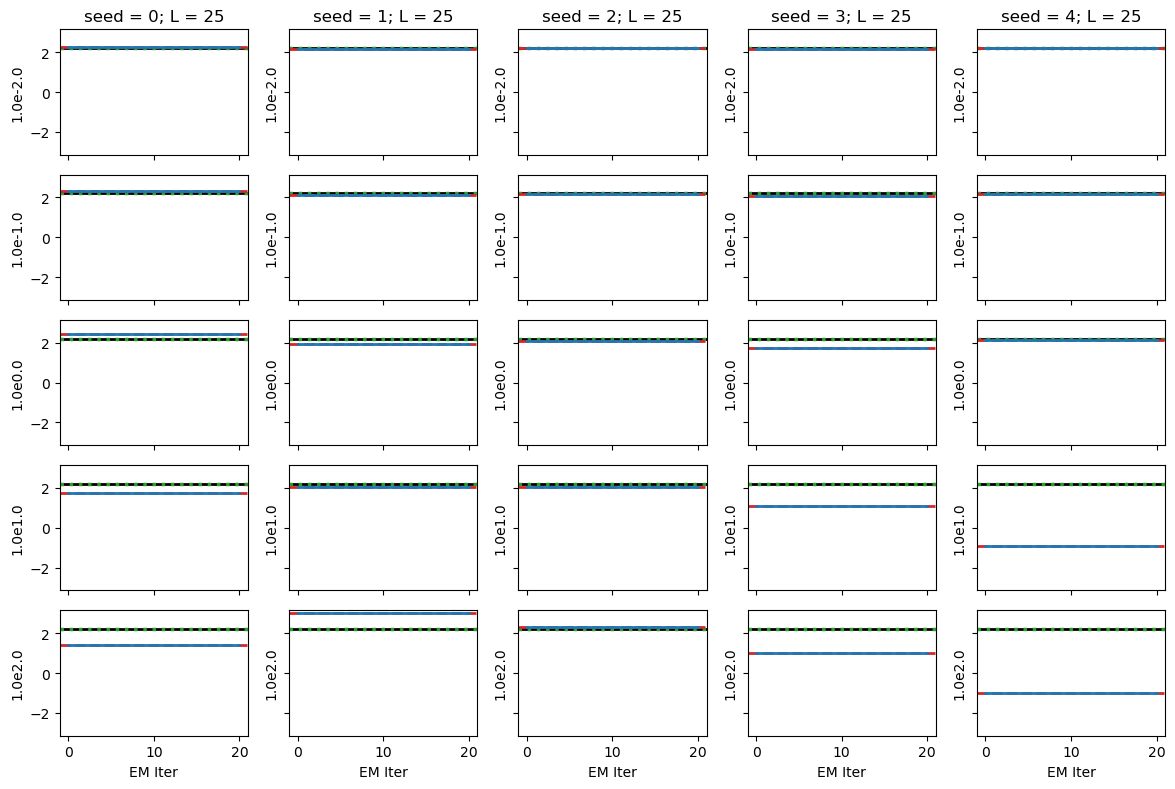

In [20]:
nseeds = 5
seeds = [x + nseeds*m for x in range(nseeds)]

funcs = [jnp.angle, jnp.abs, jnp.real, jnp.imag]
funcnames = ['Phase', 'Mag', 'Real', 'Imag']

f = 0
func, funcname = funcs[f], funcnames[f]
dim = 1


fig, ax = plt.subplots(len(thetas), len(seeds), figsize=(12,8), sharex=True, sharey='row')

# for l, L in enumerate(Ls):
l = 0
L = Ls[0]
for s, seed_use in enumerate(seeds):
    cfg.latent.gamma_seed = gseed_use
    cfg.latent.seed = seed_use
    cfg.obs.seed = seed_use
    nz_model = jnp.array([cfg.latent.target_freq_ind])

    plot_data = get_plot_dict_eigvecs(cfg)

    for t, theta in enumerate(thetas):
        axp = ax[t,s]

        plot_eigvec_var_L_subplot(ax[t,s], plot_data[t,l], dim, func, funcname)

        if l == 0:
            ax[t,s].set_ylabel(f'{get_theta_label(cfg.obs, theta)}')
        if t == 0:
            ax[t,s].set_title(f'seed = {seed_use}; L = {L}')
        if t == len(thetas)-1:
            ax[t,s].set_xlabel('EM Iter')
        if funcname == 'Phase':
            ax[t,s].set_ylim([-jnp.pi,jnp.pi])

plt.tight_layout()